#### データの全体像
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「7」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えている。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなる。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられている。

In [5]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

#### ライブラリのインポート

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

import gc
import warnings
warnings.simplefilter("ignore")

#### データの読み込み

In [7]:
%%time
# train = pd.read_csv("/kaggle/input/mercari-dataset/train.tsv", delimiter='\t')
# test = pd.read_csv("/kaggle/input/mercari-dataset/test.tsv", delimiter='\t')
train = pd.read_csv("train.tsv", delimiter='\t')
test = pd.read_csv("test.tsv", delimiter='\t')

CPU times: user 5.72 s, sys: 739 ms, total: 6.46 s
Wall time: 7.62 s


In [8]:
print(train.shape)
print(train.info())
display(train.head())

(1482535, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [9]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id  693359 non-null  int64 
 3   category_name      690301 non-null  object
 4   brand_name         397834 non-null  object
 5   shipping           693359 non-null  int64 
 6   item_description   693359 non-null  object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB
None


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


#### データの前処理

#### `price`を対数変換

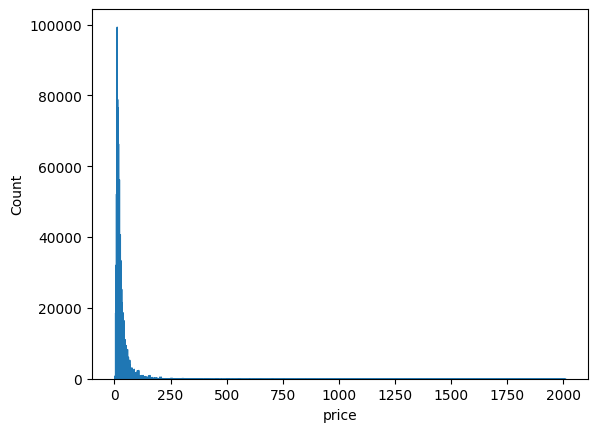

In [10]:
plt.figure()
sns.histplot(train['price'], element = 'poly')
plt.show()

In [11]:
%%time
train['price'] = np.log1p(train['price'])

CPU times: user 39.1 ms, sys: 2.33 ms, total: 41.4 ms
Wall time: 11.6 ms


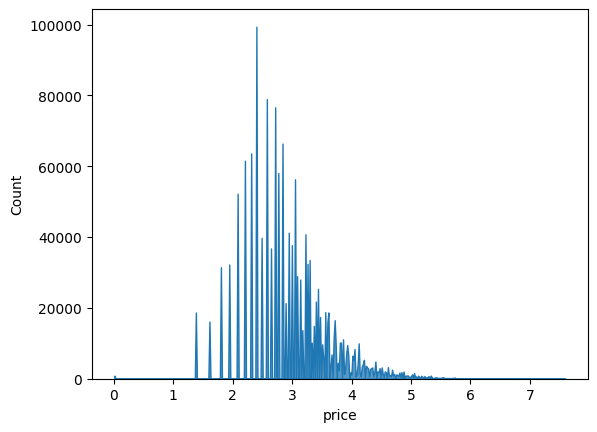

In [12]:
plt.figure()
sns.histplot(train['price'], element = 'poly')
plt.show()

#### `category_name`を3等分する

In [13]:
%%time
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") # メモ: たとえば null としたらスコアは変化する？

train['general_cat'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].apply(lambda x: split_cat(x))) # zip(*df)で転置
display(train.head())
test['general_cat'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))
display(test.head())

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


CPU times: user 6.34 s, sys: 207 ms, total: 6.55 s
Wall time: 7.21 s


#### train, test を行方向に結合し、まとめて前処理できるようにする

In [14]:
y = train['price'] # 目的変数
train.drop(['price'], axis=1, inplace=True)

# 列名をidに変更
train.rename(columns={'train_id': 'id'}, inplace=True)
test.rename(columns={'test_id': 'id'}, inplace=True)

# データフレームを結合
train_test_combine = pd.concat([train,test]) # axis=0で行、axis=1で列に結合 デフォルトはaxis=0
print(train_test_combine.shape)
train_test_combine.head()

(2175894, 10)


,id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


#### 欠損値処理


In [15]:
train_test_combine.isnull().sum()

id                        0
name                      0
item_condition_id         0
category_name          9385
brand_name           928207
shipping                  0
item_description          6
general_cat               0
sub_cat1                  0
sub_cat2                  0
dtype: int64

In [16]:
%%time
# 欠損値を 'missing'で埋める 
# メモ: null にしたらスコアは変化する？
train_test_combine['brand_name'].fillna(value='missing', inplace=True)
train_test_combine['category_name'].fillna(value='missing', inplace=True)
train_test_combine['item_description'].fillna(value='missing', inplace=True)

CPU times: user 192 ms, sys: 9.09 ms, total: 201 ms
Wall time: 204 ms


In [17]:
# ベクトル化（カウントやTF-IDF）およびエンコーディング（ONE-HOT）の前にメモリをクリアしておく
gc.collect()

0

#### 特徴エンコーディング｜CountVectorizer(), TfidfVectorizer()

**`name`に CountVectorizer を使用する理由**
- **短いテキスト**: 商品名は通常短いテキストで、単語の出現回数が直接的な特徴として有用であることが多い。
- **単純な頻度**: 単語の出現頻度を重視することで、商品名の違いを強調できる。

**`item_description`に TfidfVectorizer を使用する理由**
- **長いテキスト**: 商品説明は通常長めで、単語数が多く、情報量が多い。
- **重要度の重み付け**: TF-IDFは、頻出しすぎる単語の影響を抑え、より重要な単語に重みを置く。これにより、商品説明内の特徴的な情報を抽出しやすくなる。
- **n-gram考慮**: n-gramを使うことで、単語の組み合わせが持つ特徴も捉えることができる。

In [18]:
%%time
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(train_test_combine['name'])

tfidf = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf.fit_transform(train_test_combine['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (2175894, 131042)
item_description vectorization shape: (2175894, 50000)
CPU times: user 2min 32s, sys: 19.3 s, total: 2min 51s
Wall time: 3min 15s


#### 特徴エンコーディング｜OneHotEncoder()

#### `brand_name`に CountVectorizer() や TfidfVectorizer() ではなく OneHotEncoder() を使う理由

1. **カテゴリデータの性質**:
   - `brand_name`は通常、固有名詞で構成されるカテゴリデータである。
   - 単語の頻度や重要度ではなく、単純なカテゴリとして扱うのが適切である。

2. **OneHotEncoderの適用**:
   - 各ブランドを個別のカテゴリとしてエンコードし、独立した特徴量に変換する。
   - この方法により、ブランド間の違いを明確にモデルに示すことができる。

3. **CountVectorizerやTfidfVectorizerの不適性**:
   - これらはテキストデータの単語頻度や重要度を計算するための手法であり、カテゴリデータの単純な区別には向いていない。

#### `item_condition_id`や`shipping`に OneHotEncoder() を適用する理由は、これらのデータがカテゴリデータとして扱われるべきだからである。

1. **カテゴリデータとしての扱い**:
   - これらの変数は整数型だが、実際にはカテゴリ的な意味合いを持つ。
   - 例えば、`item_condition_id`は商品の状態を表すカテゴリであり、数値の大小に意味はない。

2. **モデルへの影響**:
   - 数値のまま扱うと、モデルはそれらに順序や距離の情報があると誤解する可能性がある。
   - ワンホットエンコーディングにより、各カテゴリを独立した特徴量として扱うことで、誤解を防ぐ。

3. **情報の独立性**:
   - 各条件や配送方法を独立した特徴量にすることで、モデルが個別の影響を学習しやすくなる。

In [19]:
%%time
ohe = OneHotEncoder()

# OneHotEncoderは2次元の入力を必要とするため、.reshape(-1, 1)で1次元のSeriesを2次元に変換
X_brand_name = ohe.fit_transform(train_test_combine['brand_name'].values.reshape(-1, 1))
X_item_condition_id = ohe.fit_transform(train_test_combine['item_condition_id'].values.reshape(-1, 1))
X_shipping = ohe.fit_transform(train_test_combine['shipping'].values.reshape(-1, 1))
X_general_cat = ohe.fit_transform(train_test_combine['general_cat'].values.reshape(-1, 1))
X_sub_cat1 = ohe.fit_transform(train_test_combine['sub_cat1'].values.reshape(-1, 1))
X_sub_cat2 = ohe.fit_transform(train_test_combine['sub_cat2'].values.reshape(-1, 1))

CPU times: user 1.86 s, sys: 92.3 ms, total: 1.96 s
Wall time: 2.14 s


In [20]:
print('brand encoding shape:', X_brand_name.shape)
print('item condition id encoding shape:', X_item_condition_id.shape)
print('shipping encoding shape:', X_shipping.shape)
print('general_cat encoding shape:', X_general_cat.shape)
print('sub_cat1 encoding shape:', X_sub_cat1.shape)
print('sub_cat2 encoding shape:', X_sub_cat2.shape)

brand encoding shape: (2175894, 5290)
item condition id encoding shape: (2175894, 5)
shipping encoding shape: (2175894, 2)
general_cat encoding shape: (2175894, 11)
sub_cat1 encoding shape: (2175894, 114)
sub_cat2 encoding shape: (2175894, 883)


#### name, item_description の単語数をカウントした列を追加

In [21]:
# %%time
# import re
# import string
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# def wordCount(text):
#     """
#     Parameters:
#       text(str): 商品名、商品の説明文
#     """
#     try:
#         if text == 'No description yet':
#             return 1  # 商品名や説明が'No description yet'の場合は1を返す
#         else:
#             text = text.lower()  # すべて小文字にする
#             # 正規表現を使用して句読点や数字を削除
#             regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
#             text = regex.sub(" ", text)
#             # ストップワードを除去
#             words = [w for w in text.split() if w and w not in ENGLISH_STOP_WORDS and len(w) >= 3]
#             return len(words)  # 単語の数を返す
#     except: 
#         return 0


# # 'name'の各フィールドの単語数を'name_len'に登録
# train_test_combine['name_len'] = train_test_combine['name'].apply(lambda x: wordCount(x))
# # 'item_description'の各フィールドの単語数を'desc_len'に登録
# train_test_combine['desc_len'] = train_test_combine['item_description'].apply(lambda x: wordCount(x))

#### 特徴ベクトル化されたスパース行列とワンホットエンコードされたスパース行列を結合する

このコードは、データを訓練用とテスト用に分割し、各特徴量を結合して疎行列（sparse matrix）を作成している。

1. **データ分割**:
   - `1482535`は訓練データとテストデータを分けるインデックス。
   - `[:1482535]`は訓練データの範囲。
   - `[1482535:]`はテストデータの範囲。

2. **特徴量の結合**:
   - `hstack()`を使用して各特徴量の行列を水平に結合。
   - 結果として、全ての特徴量が一つの大きな行列として表現される。

3. **疎行列（sparse matrix）**:
   - `tocsr()`は、行圧縮形式（Compressed Sparse Row format）で格納。
   - メモリ効率が良く、大規模データに適している。

4. **ターゲット変数**:
   - `y_train`は訓練データのターゲット変数を格納。

**エンコーディングする前の列は説明変数に加えない**  
情報の重複と多重共線性のリスクを避けるためである。エンコーディングされたデータは元のテキストデータの情報を包含しているため、元の列を残すと過剰な情報がモデルの性能を低下させる可能性がある。

In [22]:
%%time
combined_matrix_train = (X_name[:1482535], X_descp[:1482535], X_brand_name[:1482535], X_item_condition_id[:1482535], X_shipping[:1482535],
                   X_general_cat[:1482535], X_sub_cat1[:1482535], X_sub_cat2[:1482535])
X = hstack(combined_matrix_train).tocsr() # 説明変数

combined_matrix_test = (X_name[1482535:], X_descp[1482535:], X_brand_name[1482535:], X_item_condition_id[1482535:], X_shipping[1482535:],
                   X_general_cat[1482535:], X_sub_cat1[1482535:], X_sub_cat2[1482535:])
test = hstack(combined_matrix_test).tocsr()

CPU times: user 517 ms, sys: 351 ms, total: 868 ms
Wall time: 981 ms


In [23]:
print(X.shape) # 説明変数
print(test.shape)

(1482535, 187347)
(693359, 187347)


#### モデルの作成と学習

#### X と y のうち、7割を訓練用 (train)、3割を検証用 (test) に分割する

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1037774, 187347)
(1037774,)
(444761, 187347)
(444761,)


In [26]:
%%time
lgbm = lgb.LGBMRegressor(n_estimators=200, max_depth=10, random_state=0, n_jobs=-1)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 112.941748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068809
[LightGBM] [Info] Number of data points in the train set: 1037774, number of used features: 65354
[LightGBM] [Info] Start training from score 2.979505
CPU times: user 41min 21s, sys: 33.2 s, total: 41min 54s
Wall time: 4min 48s


LGBMRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=0)

#### 訓練データに対する予測｜LightGBM

In [27]:
y_train_pred = lgbm.predict(X_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [28]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

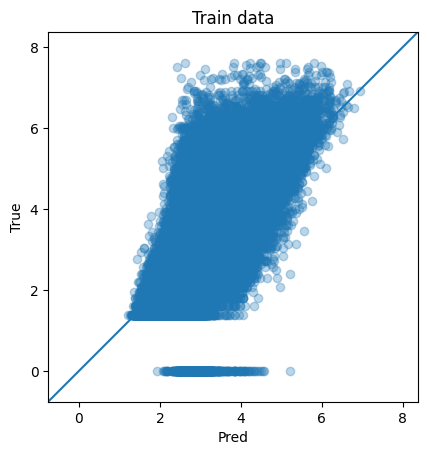

In [29]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [30]:
# RMSLE関数の定義
def rmsle(y_true, y_pred):  
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [31]:
# モデルの評価
lgb_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", lgb_train_rmsle)

RMSLE for train data: 0.5278589581642402


#### テストデータに対する予測｜LightGBM

In [32]:
y_test_pred = lgbm.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [33]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

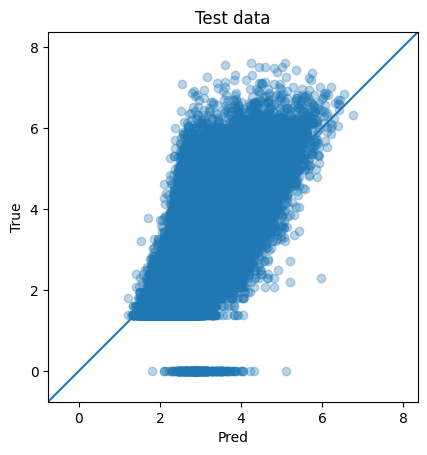

In [34]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [35]:
# モデルの評価
lgb_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", lgb_test_rmsle)

RMSLE for test data: 0.5279782525144142


In [36]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)

0:08:33.964627
